In [1]:
import re
import random
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam

import spacy
from spacy.compat import pickle

!pip install cytoolz

import cytoolz

SPACY_CORE_MODEL = 'es_core_news_md'
spacy.cli.download(SPACY_CORE_MODEL)

Using TensorFlow backend.


     |████████████████████████████████| 481kB 2.7MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp36-cp36m-linux_x86_64.whl size=1257642 sha256=7c73d45f01e649377fa5600252e08aa4c3aabe5f6b9b0a7b34a52908b8c8d170
  Stored in directory: /root/.cache/pip/wheels/64/2a/18/d962b614e055577e7d9a3e4813e0742f822ca9c8800cc3783a
Successfully built cytoolz
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime/2020_04_27

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Sentime/2020_04_27


In [0]:
# Preprocessing
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical

def read_data(data_dir, limit=0):
    dataset = pd.read_csv(data_dir / 'data.csv')
    dataset = dataset[dataset['sentiment'] != 'MIXED']
    dataset = dataset[dataset['sentiment'] != 'NEUTRAL']

    tweets = [str(tweet) for tweet in dataset['tweet']]
    sentiments = dataset['sentiment']
    sentiments[sentiments == 'POSITIVE'] = 1
    sentiments[sentiments == 'NEGATIVE'] = 0

    # sentiments = LabelEncoder()
    # sentiments = sentiments.fit_transform(dataset['sentiment'])
    # sentiments = to_categorical(sentiments)

    examples = zip(tweets, sentiments)
    examples = list(examples)

    if limit >= 1:
      examples = examples[:limit]

    return zip(*examples)  # Unzips into two lists

def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, np.asarray(labels, dtype="int32")

def get_features(docs, max_length):
    docs = list(docs)
    Xs = np.zeros((len(docs), max_length), dtype="int32")
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [0]:
class SentimentAnalyser():
    @staticmethod
    def get_embeddings(vocab):
      return vocab.vectors.data

    @classmethod
    def load(cls, path, nlp, max_length=100):
      with (path / "config.json").open() as file_:
          model = model_from_json(file_.read())
      with (path / "model").open("rb") as file_:
          lstm_weights = pickle.load(file_)
      embeddings = cls.get_embeddings(nlp.vocab)
      model.set_weights([embeddings] + lstm_weights)

      return cls(model, max_length=max_length)

    @classmethod
    def predict(cls, model_dir, text, max_length=100):
      nlp = spacy.load(SPACY_CORE_MODEL)
      nlp.add_pipe(nlp.create_pipe("sentencizer"))
      nlp.add_pipe(cls.load(model_dir, nlp, max_length))

      return nlp.pipe(texts, batch_size=1000)

    @classmethod
    def evaluate(cls, model_dir, texts, labels, max_length=100):
      docs = cls.predict(model_dir, texts, max_length)
      correct = 0
      i = 0
      for doc in docs:
          correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
          i += 1
      return float(correct) / i

    def __init__(self, model, max_length=100):
      self._model = model
      self.max_length = max_length

    def __call__(self, doc):
      X = get_features([doc], self.max_length)
      y = self._model.predict(X)
      self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000):
      for minibatch in cytoolz.partition_all(batch_size, docs):
          minibatch = list(minibatch)
          sentences = []
          for doc in minibatch:
              sentences.extend(doc.sents)
          Xs = get_features(sentences, self.max_length)
          ys = self._model.predict(Xs)
          for sent, label in zip(sentences, ys):
              sent.doc.sentiment += label - 0.5
          for doc in minibatch:
              yield doc

    def set_sentiment(self, doc, y):
      doc.sentiment = float(y[0])
      # Sentiment has a native slot for a single float.
      # For arbitrary data storage, there's:
      # doc.user_data['my_data'] = y

In [0]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape["max_length"],
            trainable=False,
            weights=[embeddings],
            mask_zero=True,
        )
    )
    model.add(TimeDistributed(Dense(shape["nr_hidden"], use_bias=False)))
    model.add(
        Bidirectional(
            LSTM(
                shape["nr_hidden"],
                recurrent_dropout=settings["dropout"],
                dropout=settings["dropout"],
            )
        )
    )
    model.add(Dense(shape["nr_class"], activation="sigmoid"))
    model.compile(
        optimizer=Adam(lr=settings["lr"]),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [8]:
model_dir=pathlib.Path('model_lstm') # Location of output model directory
train_dir=pathlib.Path('train') # Location of training file or directory
dev_dir=pathlib.Path('test') # Location of development file or directory
nr_hidden=64 # Number of hidden units
max_length=100  # Shape - Maximum sentence length
dropout=0.5 # Dropout
learn_rate=0.001  # General NN config
nb_epoch=5 # Number of training epochs
batch_size=256 # Size of minibatches for training LSTM
nr_examples=-1 # Limit to N examples
lstm_shape = {"nr_hidden": nr_hidden, "max_length": max_length, "nr_class": 1}
lstm_settings = {"dropout": dropout, "lr": learn_rate}

print("Read data")
train_texts, train_labels = read_data(train_dir, limit=nr_examples)
dev_texts, dev_labels = read_data(dev_dir, limit=nr_examples)

train_labels = np.asarray(train_labels, dtype="int32")
dev_labels = np.asarray(dev_labels, dtype="int32")

print("Loading spaCy")
nlp = spacy.load(SPACY_CORE_MODEL)
nlp.add_pipe(nlp.create_pipe("sentencizer"))
embeddings = SentimentAnalyser.get_embeddings(nlp.vocab)
model = compile_lstm(embeddings, lstm_shape, lstm_settings)

print("Parsing texts...")
train_docs = list(nlp.pipe(train_texts))
dev_docs = list(nlp.pipe(dev_texts))

train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

train_X = get_features(train_docs, lstm_shape["max_length"])
dev_X = get_features(dev_docs, lstm_shape["max_length"])

Read data
Loading spaCy
Parsing texts...


In [9]:
history = model.fit(
    train_X,
    train_labels,
    validation_data=(dev_X, dev_labels),
    epochs=nb_epoch,
    batch_size=batch_size,
)

Train on 11108 samples, validate on 5025 samples
Epoch 1/5
11108/11108 [==============================] - 40s 4ms/step - loss: 0.6723 - accuracy: 0.6165 - val_loss: 0.6776 - val_accuracy: 0.5996
Epoch 2/5
11108/11108 [==============================] - 37s 3ms/step - loss: 0.6631 - accuracy: 0.6259 - val_loss: 0.6770 - val_accuracy: 0.5992
Epoch 3/5
11108/11108 [==============================] - 36s 3ms/step - loss: 0.6626 - accuracy: 0.6268 - val_loss: 0.6804 - val_accuracy: 0.5996
Epoch 4/5
11108/11108 [==============================] - 36s 3ms/step - loss: 0.6611 - accuracy: 0.6278 - val_loss: 0.6752 - val_accuracy: 0.5996
Epoch 5/5
11108/11108 [==============================] - 35s 3ms/step - loss: 0.6620 - accuracy: 0.6269 - val_loss: 0.6785 - val_accuracy: 0.5996


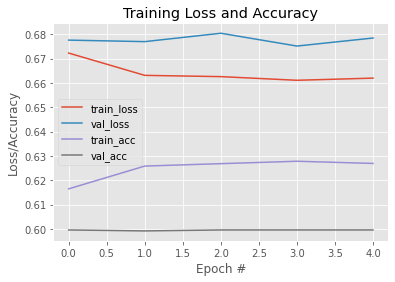

In [10]:
plt.style.use('ggplot')
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='best')

In [0]:
# Save model
weights = model.get_weights()
if model_dir is not None:
    with (model_dir / "model").open("wb") as file_:
        pickle.dump(weights[1:], file_)
    with (model_dir / "config.json").open("w") as file_:
        file_.write(model.to_json())

In [13]:
# Evaluate
# texts = ['Amo a char', 'Odio a char']
# labels = [1.0, 0.0]
# SentimentAnalyser.evaluate(pathlib.Path('model_lstm'), texts, labels)

0.75